### import library

In [53]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

### recycle garbage classification
1. paper
2. glass
3. can
4. metal
5. clothes
6. plastic
7. box

In [54]:
IMAGE_SIZE = 299
BATCH_SIZE = 32

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Preprocessing과 Data Loading을 동시에 적용. 단 실제 Preprocessing과 Data Loading을 Model에서 fit_generator()를 호출하기 전까지는 동작하지 않음. 
# augmentation은 horizontal_flip(좌우 반전)만 적용하고 0 ~ 255의 pixel값을 0 ~ 1 로 scale만 적용. 

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rescale=1/255.,
                               rotation_range=45,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.1,
                               vertical_flip=True,
                               validation_split=0.2
                              )

train_flow_gen = train_gen.flow_from_directory(directory='data',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='sparse',
                                               batch_size=BATCH_SIZE,
                                               subset='training'
                                               )

valid_flow_gen = train_gen.flow_from_directory(directory='data',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='sparse',
                                               batch_size=BATCH_SIZE,
                                               subset='validation'
                                               )

Found 15895 images belonging to 9 classes.
Found 3971 images belonging to 9 classes.


In [56]:
# next()를 flow_from_directory()로 반환된 Iterator 객체를 강제로 호출하여 어떤 값이 만들어 지는지 확인.  
# 튜플형태로 반환되고 튜플의 첫번째값은 image array, 두번째 값은 label array 임
# image array는 0~1 사이 값인 float32로 변환됨. label array는 2개 column으로 원-핫 인코딩 됨. 
# next(iter(train_flow_gen))
images_array, labels_array = next(train_flow_gen)
print(images_array.shape, labels_array.shape)
print(images_array[:1], labels_array[:1])

(32, 299, 299, 3) (32,)
[[[[1.8959680e-01 1.6998896e-01 9.0480238e-02]
   [1.7850471e-01 1.6541752e-01 9.0246469e-02]
   [1.6117899e-01 1.4941429e-01 8.1179991e-02]
   ...
   [1.6925699e-01 1.5749228e-01 9.7777940e-02]
   [1.8061540e-01 1.6885069e-01 1.1002716e-01]
   [1.8172944e-01 1.6996473e-01 1.1114120e-01]]

  [[1.8722835e-01 1.6765438e-01 8.9239947e-02]
   [1.8053381e-01 1.6855785e-01 9.3942426e-02]
   [1.4889112e-01 1.3712640e-01 7.0003353e-02]
   ...
   [8.1726402e-02 6.9335148e-02 3.6082966e-03]
   [8.8446654e-02 7.6681949e-02 1.0502773e-02]
   [1.0237217e-01 9.0607464e-02 2.5542332e-02]]

  [[1.7832114e-01 1.5985842e-01 8.1999592e-02]
   [1.6518851e-01 1.5342380e-01 7.9813980e-02]
   [1.3188666e-01 1.2071329e-01 5.3909738e-02]
   ...
   [8.0125071e-02 6.0154956e-02 4.3473025e-03]
   [7.5261571e-02 5.6405496e-02 3.7588304e-04]
   [7.6375611e-02 5.8633581e-02 9.3290367e-04]]

  ...

  [[5.5372292e-01 4.9175960e-01 1.8353200e-01]
   [5.4690671e-01 4.8416159e-01 1.7827921e-01]
  

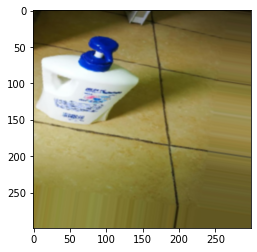

In [57]:
plt.imshow(images_array[:1].reshape(IMAGE_SIZE,IMAGE_SIZE,3), interpolation='bicubic')

In [58]:
# image array와 label array의 shape 확인. 
# batch_size만큼 한꺼번에 추출되므로 image array는 4차원, label array는 batch_size와 원-핫 인코딩을 감안하여 2차원 데이터
images_array = next(train_flow_gen)[0]
labels_array = next(train_flow_gen)[1]
print('##### image array shape:', images_array.shape)
print('#### label array shape:', labels_array.shape)

##### image array shape: (32, 299, 299, 3)
#### label array shape: (32,)


In [59]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras import regularizers

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(9, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model


In [60]:
# 위에서 flow_from_directory(class_mode='categorical') 로 설정했기에 label은 원핫 인코딩 되어 모델로 입력됨
# loss 는 원핫 인코딩을 기반으로 계산이 될 수 있는 loss 함수 필요. 여기서는 categorical_crossentropy를 써야함
# 만약 위에서 class_mode='sparse' 라면 loss는 sparse_categorical_crossentropy 여야 함.
model = create_model(model_name='resnet50', verbose=True)
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 3회 0.2
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5회 Earlystopping
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 305, 305, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

C:\Users\acsl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
# train 데이터 건수는 generator의 samples 속성을 이용하여 가져올 수 있음. 
train_image_cnt = train_flow_gen.samples
valid_image_cnt = valid_flow_gen.samples
print(train_image_cnt)
print(valid_image_cnt)
# batch size는 64, 학습 데이터 image 개수는 8005 
history = model.fit(train_flow_gen,
          epochs=100,
          steps_per_epoch=int(np.ceil(train_image_cnt/BATCH_SIZE)),
          validation_data=valid_flow_gen,
          validation_steps=int(np.ceil(valid_image_cnt/BATCH_SIZE)),
          callbacks=[rlr_cb, ely_cb]
        )
# 앞으론 fit()을 사용해야함. (fit_generator()와 같이 동작함)
# model.fit(train_flow_gen, epochs=15, steps_per_epoch=int(np.ceil(train_image_cnt/BATCH_SIZE)))

15895
3971
Epoch 1/100
497/497 [==============================] - 299s 591ms/step - loss: 1.6721 - accuracy: 0.4130 - val_loss: 5.3810 - val_accuracy: 0.1775 - lr: 0.0010
Epoch 2/100
497/497 [==============================] - 243s 488ms/step - loss: 1.3602 - accuracy: 0.5286 - val_loss: 2.0504 - val_accuracy: 0.3976 - lr: 0.0010
Epoch 3/100
497/497 [==============================] - 241s 484ms/step - loss: 1.1902 - accuracy: 0.5927 - val_loss: 2.1677 - val_accuracy: 0.4090 - lr: 0.0010
Epoch 4/100
497/497 [==============================] - 237s 476ms/step - loss: 1.0825 - accuracy: 0.6260 - val_loss: 1.5065 - val_accuracy: 0.4961 - lr: 0.0010
Epoch 5/100
497/497 [==============================] - 239s 480ms/step - loss: 1.0097 - accuracy: 0.6505 - val_loss: 1.2290 - val_accuracy: 0.6084 - lr: 0.0010
Epoch 6/100
497/497 [==============================] - 238s 479ms/step - loss: 0.9438 - accuracy: 0.6732 - val_loss: 1.4046 - val_accuracy: 0.5585 - lr: 0.0010
Epoch 7/100
497/497 [========

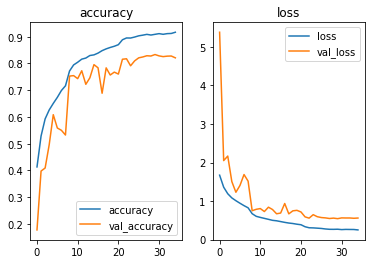

In [62]:
# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("accuracy")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("loss")
plt.legend()

plt.show()

In [63]:
model.save('model/garbage_classification_resnet.h5')

model = tf.keras.models.load_model("model/garbage_classification_resnet.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('model/garbage_classification_resnet.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\acsl\AppData\Local\Temp\tmpsjy2kgt0\assets


INFO:tensorflow:Assets written to: C:\Users\acsl\AppData\Local\Temp\tmpsjy2kgt0\assets


94505384